In [1]:
library(tidyverse)
library(readr)
library(dplyr)
library(stringr)
library(tidymodels)
library(yardstick)
library(ggplot2)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod"
file_path <- "cleve.mod"
download.file(url, destfile = file_path)
heart_data <- read_table(file_path, skip = 20, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                                                    "thalach", "exang", "oldpeak", "slope", "ca", "thal", 
                                                                    "disease"), na = "?")

heart_data$disease <- str_replace_all(string = heart_data$disease, pattern = "buff", replacement = "healthy")
head(heart_data)


── Column specification ────────────────────────────────────────────────────────
cols(
  age = col_double(),
  sex = col_character(),
  cp = col_character(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_character(),
  restecg = col_character(),
  thalach = col_double(),
  exang = col_character(),
  oldpeak = col_double(),
  slope = col_character(),
  ca = col_double(),
  thal = col_character(),
  disease = col_character()
)

Warning message:
“303 parsing failures.
row col   expected     actual        file
  1  -- 14 columns 15 columns 'cleve.mod'
  2  -- 14 columns 15 columns 'cleve.mod'
  3  -- 14 columns 15 columns 'cleve.mod'
  4  -- 14 columns 15 columns 'cleve.mod'
  5  -- 14 columns 15 columns 'cleve.mod'
... ... .......... .......... ...........
See problems(...) for more details.
”


age sex  cp     trestbps chol fbs  restecg thalach exang oldpeak slope ca
1 63  male angina 145      233  true hyp     150     fal   2.3     down  0 
2 67  male asympt 160      286  fal  hyp     108     true  1.5     flat  3 
3 67  male asympt 120      229  fal  hyp     129     true  2.6     flat  2 
4 37  male notang 130      250  fal  norm    187     fal   3.5     down  0 
5 41  fem  abnang 130      204  fal  hyp     172     fal   1.4     up    0 
6 56  male abnang 120      236  fal  norm    178     fal   0.8     up    0 
  thal disease
1 fix  healthy
2 norm sick   
3 rev  sick   
4 norm healthy
5 norm healthy
6 norm healthy

In [3]:
set.seed(8888)
# split data into training and testing data
heart_split <- initial_split(heart_data, prop = 0.75, strata = disease)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [4]:
heart_recipe <- recipe(disease ~ thalach + oldpeak, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) 
heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
heart_vfold <- vfold_cv(heart_train, v = 5, strata = disease)
heart_k <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(heart_tune) |>
  tune_grid(resamples = heart_vfold, gird = 10) |>
  collect_metrics() |>
  filter(.metric == "accuracy") 
head(heart_k)

Warning message:
“The `...` are not used in this function but one or more objects were passed: 'gird'”


neighbors .metric  .estimator mean      n std_err    .config             
1  2        accuracy binary     0.6515810 5 0.03214669 Preprocessor1_Model1
2  4        accuracy binary     0.6632411 5 0.02048674 Preprocessor1_Model2
3  5        accuracy binary     0.6940711 5 0.02675951 Preprocessor1_Model3
4  7        accuracy binary     0.6851779 5 0.02759307 Preprocessor1_Model4
5  9        accuracy binary     0.7120553 5 0.03435781 Preprocessor1_Model5
6 10        accuracy binary     0.7166008 5 0.03126405 Preprocessor1_Model6

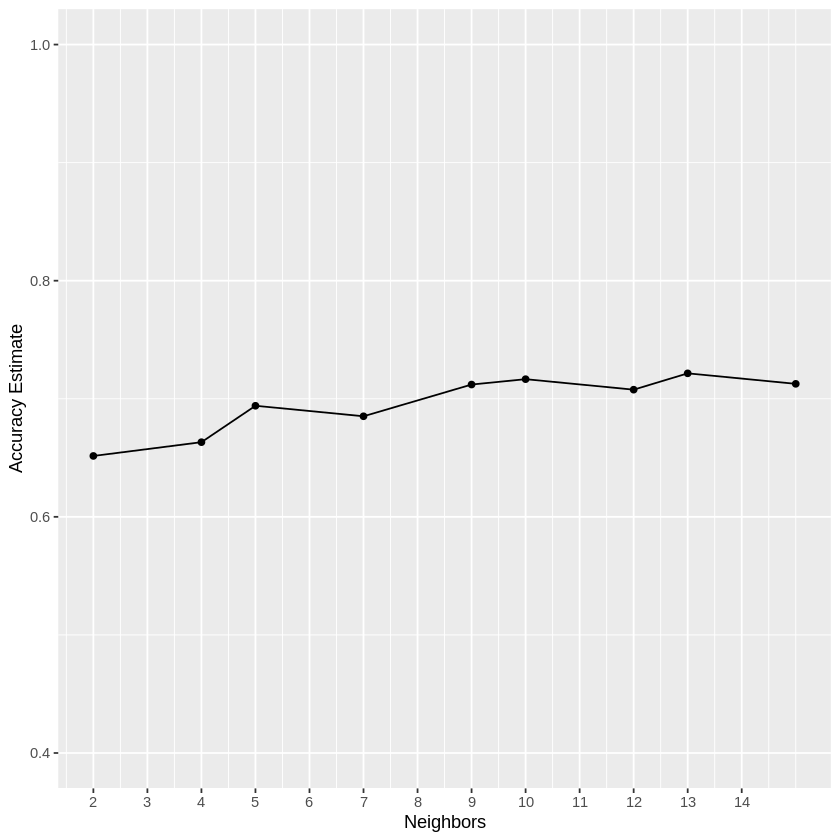

In [5]:
accuracies <- heart_k |> 
      filter(.metric=="accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

In [13]:
# k = 13 has the highest accuracy, therefore choose k = 13.
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
  set_engine("kknn") |>
  set_mode("classification")
heart_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(heart_spec) |>
  fit(data = heart_train)
# predict
heart_predict <- predict(heart_fit, heart_test) |>
  bind_cols(heart_test)
head(heart_predict)

.pred_class age sex  cp     trestbps chol fbs restecg thalach exang oldpeak
1 sick        67  male asympt 160      286  fal hyp     108     true  1.5    
2 healthy     41  fem  abnang 130      204  fal hyp     172     fal   1.4    
3 healthy     57  fem  asympt 120      354  fal norm    163     true  0.6    
4 sick        64  male angina 110      211  fal hyp     144     true  1.8    
5 healthy     58  male abnang 120      284  fal hyp     160     fal   1.8    
6 healthy     43  male asympt 150      247  fal norm    171     fal   1.5    
  slope ca thal disease
1 flat  3  norm sick   
2 up    0  norm healthy
3 up    0  norm healthy
4 flat  0  norm healthy
5 flat  0  norm sick   
6 up    0  norm healthy

In [7]:
accuracies <- knn_results |> 
      filter(.metric=="accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

ERROR: Error in eval(expr, envir, enclos): object 'knn_results' not found


In [8]:
heart_predict <- mutate(heart_predict, disease = as.factor(disease))
heart_accuracy <- heart_predict |>
  metrics(truth = disease, estimate = .pred_class) |>
  filter(.metric == "accuracy")
heart_accuracy
heart_mat <- heart_predict |>
  conf_mat(truth = disease, estimate = .pred_class)
heart_mat

.metric  .estimator .estimate
1 accuracy binary     0.7402597

          Truth
Prediction healthy sick
   healthy      36   14
   sick          6   21

In [11]:
# Create the grid of thalach/oldpeak values, and arrange in a data frame
thalach_grid <- seq(min(heart_data$thalach, na.rm = TRUE),
                    max(heart_data$thalach, na.rm = TRUE),
                    length.out = 100)
oldpeak_grid <- seq(min(heart_data$oldpeak, na.rm = TRUE),
                    max(heart_data$oldpeak, na.rm = TRUE),
                    length.out = 100)


thalach_oldpeak_grid <- as_tibble(expand.grid(thalach = thalach_grid,
                                              oldpeak = oldpeak_grid))

# Use the fit workflow to make predictions at the grid points
knn_pred_grid <- predict(heart_fit, thalach_oldpeak_grid)

# Bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knn_pred_grid, thalach_oldpeak_grid) |>
  rename(disease = .pred_class) 
head(prediction_table)

disease thalach  oldpeak
1 sick    71.00000 0      
2 sick    72.32323 0      
3 sick    73.64646 0      
4 sick    74.96970 0      
5 sick    76.29293 0      
6 sick    77.61616 0

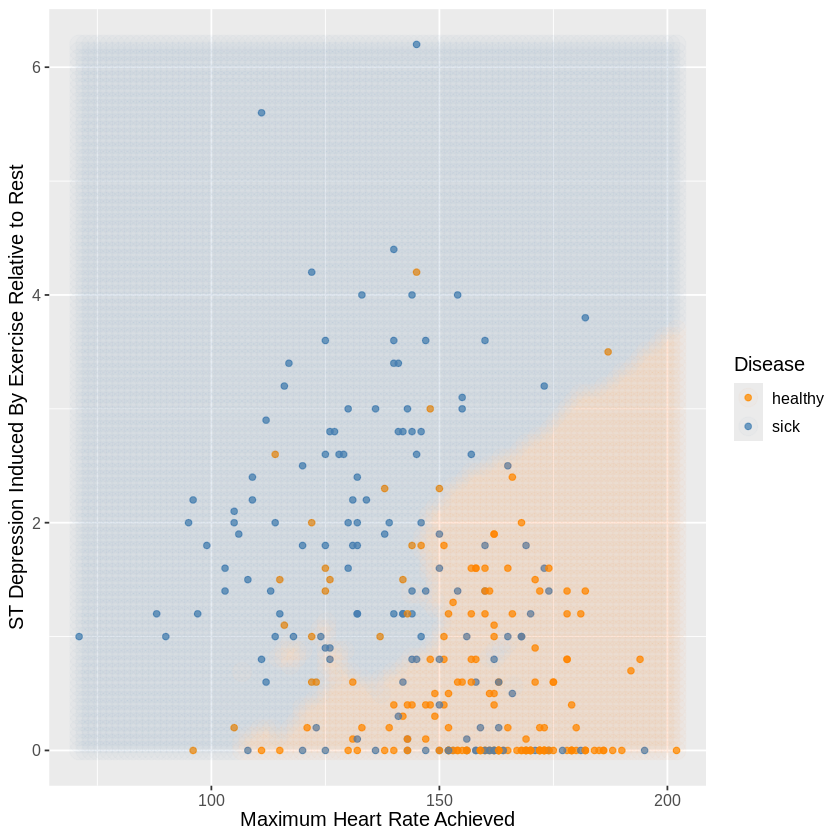

In [12]:
#plot
heart_plot <-
  ggplot() +
  geom_point(data = heart_data,
             mapping = aes(x = thalach,
                           y = oldpeak,
                           color = disease),
             alpha = 0.75) +
  geom_point(data = prediction_table,
             mapping = aes(x = thalach,
                           y = oldpeak,
                           color = disease),
             alpha = 0.02,
             size = 5) +
  labs(color = "Disease",
       x = "Maximum Heart Rate Achieved",
       y = "ST Depression Induced By Exercise Relative to Rest") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot
# Scatter plot of thalach versus oldpeak where background color indicates the decision of the classifier.